# REINFORCEMENT LEARNING IN PYTHON

## The Explore-Exploit Dilemma
#### Quantitative reasoning and algorithms to adapt
The two opposing forces:
1. Collect data about each choice (exploration)
2. Select choice with highest win rate (exploitation)

Ex. Two slot machines, collect data about success rate or choice that gets money.

Algorithms to solve this dilemma:
Epsilon-greedy, Optimistic Initial Values, UCB1 (Upper Confidence Bound), Thompson Sampling (Bayesian Bandit)

Applications:
Online advertising (comparing designs etc.), News Feeds 

### Theory of Epsilon-Greedy
Greedy means picking the bandit with highest MLE win rate, with no regard to confidence in prediction or amount of data collected

```
while True:
   j = argmax (predicted bandit means)
   x = play bandit j and get reward
   bandits[j].update_mean(x)
```
Epsilon-Greedy - Small probability of doing something random (non-greedy)
```
while True:
   p = random number in [0,1]
   if p < epsilon:
       j = choose a random bandit
   else:
       j = argmax (predicted bandit means)
   x = play bindit j and get reward
   bandits[j].update_mean(x)
```

To improve behaviour, have a decaying epsilon:
ɛ(t) proportional to 1/t, max(ɛ_0 - kt, ɛ_min), ɛ_0 * alpha^t, a / log(bt+c)

#### Calculating sample mean (Part 1)
`MeanN = MeanN-1 + 1/N (Xn - MeanN-1)`<br>
Can be evaluated in constant time and space. Storage: previous mean, newest sample, number of samples

optimal j: 2
mean estimate: 0.2222222222222222
mean estimate: 0.4859550561797755
mean estimate: 0.7444957577059409
total reward earned: 7179.0
overall win rate: 0.7179
num_times_explored: 1006
num_times_exploited: 8994
num times selected optimal bandit: 9311


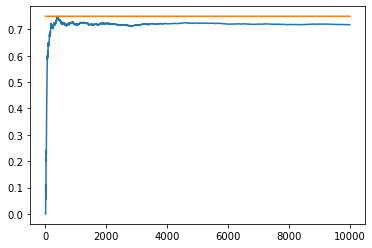

In [1]:
import matplotlib.pyplot as plt
import numpy as np


NUM_TRIALS = 10000
EPS = 0.1
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit:
  def __init__(self, p):
    self.p = p
    self.p_estimate = 0
    self.N = 0

  def pull(self):
    # draw a 1 with probability p
    return np.random.random() < self.p

  def update(self, x):
    self.N += 1
    self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N


def experiment():
  bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

  rewards = np.zeros(NUM_TRIALS)
  num_times_explored = 0
  num_times_exploited = 0
  num_optimal = 0
  optimal_j = np.argmax([b.p for b in bandits])
  print("optimal j:", optimal_j)

  for i in range(NUM_TRIALS):

    # use epsilon-greedy to select the next bandit
    if np.random.random() < EPS:
      num_times_explored += 1
      j = np.random.randint(len(bandits))
    else:
      num_times_exploited += 1
      j = np.argmax([b.p_estimate for b in bandits])

    if j == optimal_j:
      num_optimal += 1

    # pull the arm for the bandit with the largest sample
    x = bandits[j].pull()

    # update rewards log
    rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
    bandits[j].update(x)

    

  # print mean estimates for each bandit
  for b in bandits:
    print("mean estimate:", b.p_estimate)

  # print total reward
  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / NUM_TRIALS)
  print("num_times_explored:", num_times_explored)
  print("num_times_exploited:", num_times_exploited)
  print("num times selected optimal bandit:", num_optimal)

  # plot the results
  cumulative_rewards = np.cumsum(rewards)
  win_rates = cumulative_rewards / (np.arange(NUM_TRIALS) + 1)
  plt.plot(win_rates)
  plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
  plt.show()

experiment()

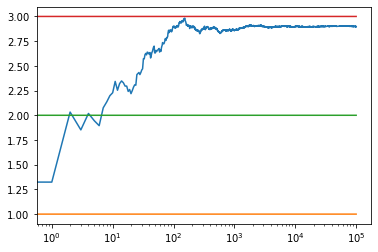

1.0187233515699277
1.9853805456003648
2.9973016843934013


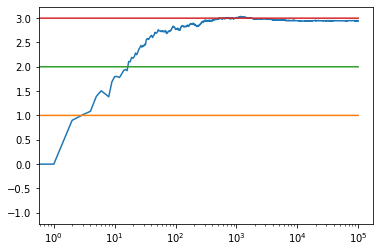

0.997286848622659
1.9781839941521702
2.99864454872375


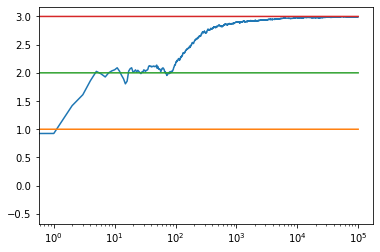

1.0348621976931336
1.9789654521066615
3.0033708201698164


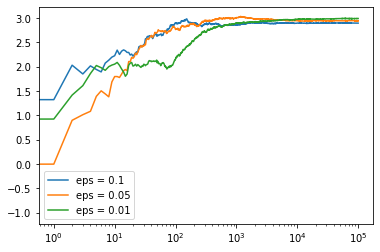

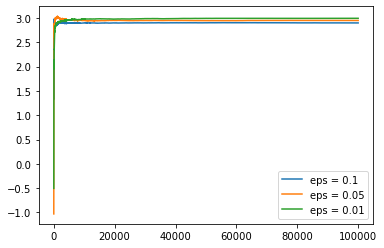

In [2]:
## COMPARING DIFFERENT VALUES OF EPSILON
import numpy as np
import matplotlib.pyplot as plt


class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x


def run_experiment_eps(m1, m2, m3, eps, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    # epsilon greedy
    p = np.random.random()
    if p < eps:
      j = np.random.choice(3)
    else:
      j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  for b in bandits:
    print(b.mean)

  return cumulative_average

if __name__ == '__main__':
  c_1 = run_experiment_eps(1.0, 2.0, 3.0, 0.1, 100000)
  c_05 = run_experiment_eps(1.0, 2.0, 3.0, 0.05, 100000)
  c_01 = run_experiment_eps(1.0, 2.0, 3.0, 0.01, 100000)

  # log scale plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(c_05, label='eps = 0.05')
  plt.plot(c_01, label='eps = 0.01')
  plt.legend()
  plt.xscale('log')
  plt.show()


  # linear plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(c_05, label='eps = 0.05')
  plt.plot(c_01, label='eps = 0.01')
  plt.legend()
  plt.show()

Different values of epsilon decide when the rewards will converge. Choose according to application, number of trials, reward value etc.

### Optimistic Initial Values Theory
Simple modification of purely greedy method, no need for epsiolon/random exploration.<br>
Instead of mean estimate = 0 (not used), initialize to a large value and use it (overestimate the mean).<br>
#### Choosing the bandit
Be greedy. Choose bandit with "largest estimated mean". Balance exploration and exploitation.<br>
Early in experiment: Less data, Estimated mean large.<br>
Later in experiment: More data, Estimated mean gets smaller until we stop choosing the bandit or it converges.
<br>
NO GUARANTEE THAT THE SAMPLE MEAN WILL CONVERGE
#### Role of initial value
Extremely high value = more exploration
Little high value = less exploration
It's a hyperparameter that controls the amount of exploration

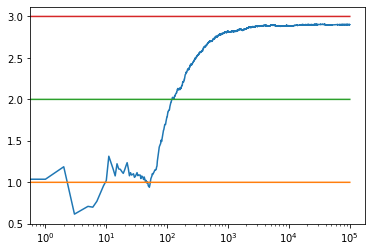

1.0090896915103629
2.0087316420346344
3.0037697387473106


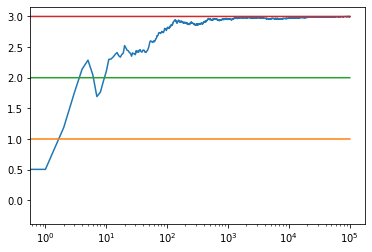

2.741939954231355
2.7796884834327464
2.997613596456401


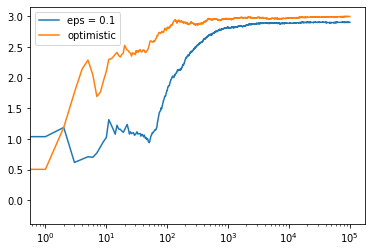

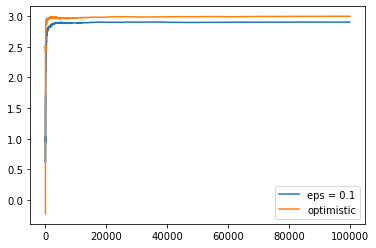

In [3]:
class Bandit_initial:
  def __init__(self, m, upper_limit):
    self.m = m
    self.mean = upper_limit
    self.N = 1

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x


def run_experiment(m1, m2, m3, N, upper_limit=10):
  bandits = [Bandit_initial(m1, upper_limit), Bandit_initial(m2, upper_limit), Bandit_initial(m3, upper_limit)]

  data = np.empty(N)
  
  for i in range(N):
    # optimistic initial values
    j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  for b in bandits:
    print(b.mean)

  return cumulative_average

if __name__ == '__main__':
  c_1 = run_experiment_eps(1.0, 2.0, 3.0, 0.1, 100000)
  oiv = run_experiment(1.0, 2.0, 3.0, 100000)

  # log scale plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(oiv, label='optimistic')
  plt.legend()
  plt.xscale('log')
  plt.show()


  # linear plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(oiv, label='optimistic')
  plt.legend()
  plt.show()


### UCB1 THEORY
Upper Confidence Bound - Use probability to get upper bound <br>
Applying probability - collecting data makes us more confident in our estimate<br>
`p(sample mean - true mean >= error) <= f(error)`<br>
f(error) is a decreasing function<br>
`p(_ _) <= e^(-2nt^2)`  -- Hoeeffding's inequality
It is basically a hyperparameter

`j = arg-max (Xnj + sqrt(2 * log(N)/nj))`<br>
EXPLOITATION - Choose bandit where mean is bigger i.e. Xnj <br>
EXPLORATION - larger when data is less, N = total plays made, nj = plays made on bandit_j)

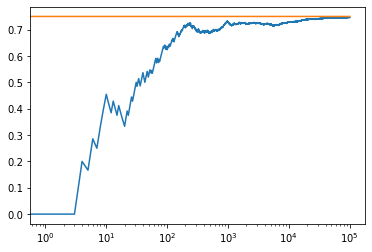

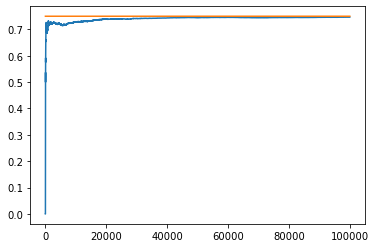

0.23809523809523808
0.540772532188841
0.7480015685801416
total reward earned: 74661.0
overall win rate: 0.74661
num times selected each bandit: [84.0, 466.0, 99453.0]


array([0.        , 0.        , 0.        , ..., 0.74660493, 0.74660747,
       0.74661   ])

In [4]:
NUM_TRIALS = 100000
EPS = 0.1
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit_UCB1:
  def __init__(self, p):
    # p: the win rate
    self.p = p
    self.p_estimate = 0.
    self.N = 0. # num samples collected so far

  def pull(self):
    # draw a 1 with probability p
    return np.random.random() < self.p

  def update(self, x):
    self.N += 1.
    self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N


def ucb(mean, n, nj):
  return mean + np.sqrt(2 * np.log(n) / nj)


def run_experiment_ucb():
  bandits = [Bandit_UCB1(p) for p in BANDIT_PROBABILITIES]
  rewards = np.empty(NUM_TRIALS)
  total_plays = 0

  # initialization: play each bandit once
  for j in range(len(bandits)):
    x = bandits[j].pull()
    total_plays += 1
    bandits[j].update(x)
  
  for i in range(NUM_TRIALS):
    j = np.argmax([ucb(b.p_estimate, total_plays, b.N) for b in bandits])
    x = bandits[j].pull()
    total_plays += 1
    bandits[j].update(x)

    # for the plot
    rewards[i] = x
  cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
  plt.xscale('log')
  plt.show()

  # plot moving average ctr linear
  plt.plot(cumulative_average)
  plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
  plt.show()

  for b in bandits:
    print(b.p_estimate)

  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / NUM_TRIALS)
  print("num times selected each bandit:", [b.N for b in bandits])

  return cumulative_average

run_experiment_ucb()

### BAYESIAN BANDITS / THOMPSON SAMPLING

__Intutive idea__ - we are interested in something like a confidence interval <br>
When the confidence level is fat, we want to explore more to improve our confidence level.<br>
When the confidence interval is skinny, we want to exploit it by choosing the band with the highest mean (which we are most confident about).<br>
Confidence intervals are based on the Central Limit Theorem (CTL) and do not actually portray the mean distribution.<br>
Instead, the Bayesian method is to treat the win rate as a random variable with its own distribution and computing a posterior from Bayes rule is not easy (intractable sums or impossible integrals) unless we use conjugate priors.<br>
Shape of the posterior fits some particular distribution. <br>
__Thompson Sampling__ - In order to choose a bandit, just rank each bandit based on the samples drawn from each posterior<br>
=> Optimal gets skinny, suboptimal remain fat. Allows us to choose optimal and avoid suboptimal (Exploit).
 
#### Pseudocode:
```
class Bandit():
  def sample():
    return beta(a,b).sample()
  
  def update(x):
    a = .., b = ..

for n in range(NUM_TRIALS):
  j = argmax(b.sample() for b in bandits)  -- argmax w.r.t. samples from posteriors and not means
  x = bandits[j].pull()
  bandit[j].update(x)
```
As we sample,<br>
if reward x = 1, posterior distribution gets skinnier and mean moves a bit up.<br>
if reward x = 0, posterior distribution still gets skinnier as we get a better estimate of the mean, vertically mean value goes down.


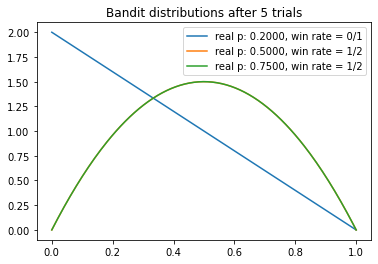

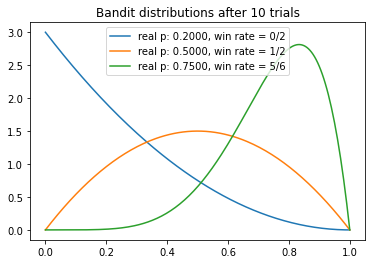

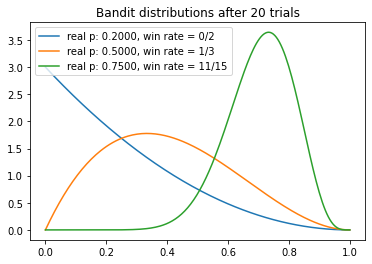

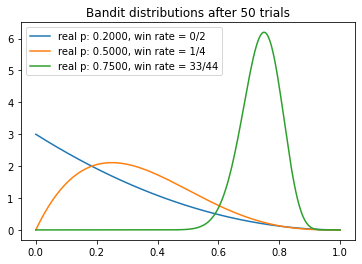

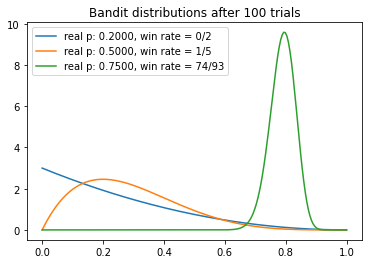

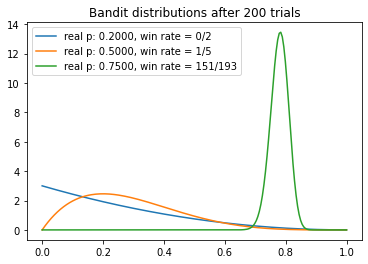

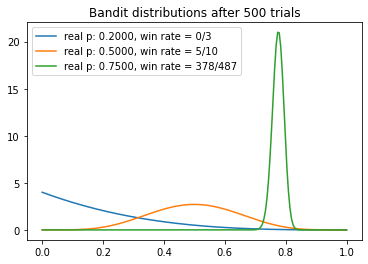

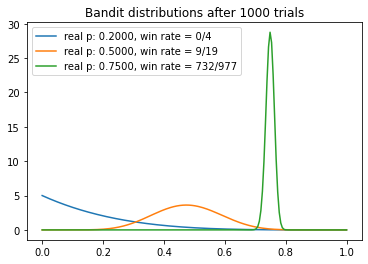

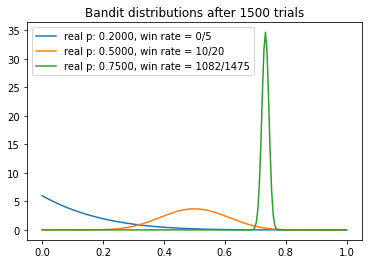

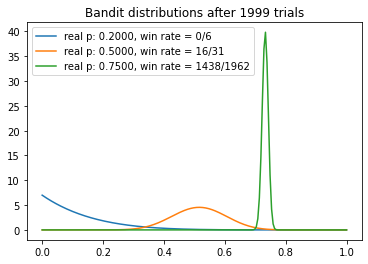

total reward earned: 1455.0
overall win rate: 0.7275
num times selected each bandit: [6, 31, 1963]


In [5]:
from scipy.stats import beta

# np.random.seed(2)
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit_Bayes:
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1
    # START WITH A UNIFORM BETA DISTRIBUTION
    self.N = 0 # for information only

  def pull(self):
    return np.random.random() < self.p

  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    # POSTERIOR BECOMES PRIOR IN EACH UPDATE ITERATION
    self.a += x
    self.b += 1 - x
    self.N += 1


def plot(bandits, trial):
  x = np.linspace(0, 1, 200)
  for b in bandits:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
  plt.title(f"Bandit distributions after {trial} trials")
  plt.legend()
  plt.show()


def experiment_bayes():
  bandits = [Bandit_Bayes(p) for p in BANDIT_PROBABILITIES]

  sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
  rewards = np.zeros(NUM_TRIALS)
  for i in range(NUM_TRIALS):
    # Thompson sampling
    j = np.argmax([b.sample() for b in bandits])

    # plot the posteriors
    if i in sample_points:
      plot(bandits, i)

    # pull the arm for the bandit with the largest sample
    x = bandits[j].pull()

    # update rewards
    rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
    bandits[j].update(x)

  # print total reward
  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / NUM_TRIALS)
  print("num times selected each bandit:", [b.N for b in bandits])

experiment_bayes()

#### Calculating sample mean (Part 2)
Stationary - Distribution does not change over time.<br>
Non-Stationary - Reward distributions change. Win-rate today 10%, tomorrow 50%; BitCoin vs USD.<br>
Weak-sense stationary - Mean and auto-covariance do not change.<br>

##### Dealing with non-stationary rewards
-- Xn = Xn-1 + 1/N (X - Xn-1)<br>
=> Xn = Xn-1 + α (X - Xn-1)<br>
=> Xn = (1-α)*Xn-1 + αX<br>
Using a constant learning rate α, we get an exponentially-weighted moving average (EWMA)

# REINFORCEMENT LEARNING

#### Contextual Bandits
Use context (male teenager vs soccer mom), based on features such as previous websites visited or explicit information from user, external to user. <br>
=> State : consists of attributes. Can be interconnected (State sequences) or disconnected (Stateless).

## Markov Decision Processes (MDPs)

### Gridworld
Learning environment for Reinforcement Learning <br>
Learning = Reinforcing desired behaviour, playing multiple times, gain experience. Each iteration is an __episode__. A __terminal state__ is a state that ends an episode. __State space__ is collection of all possible states. __Action space__ is set of all possible actions.<br>
__Policy__ is a function/equatino/NN that maps state to action (the agent's brain). Policy can be deterministic or probabilistic.<br>
__Rewards__ have to be engineered to result in the desired behaviour of agent.

### The Markov Property
Wrong but useful. Consider NLP where statements are sequences of words. <br>
To predict next word, instead of `p(st | st-1, st-2, st-3, .. s1)` consider `p(st | st-1)` i.e., bigrams. This is the __first-order Markov assumption__.<br>

### State Transition Matrix
Using maximum liklihood, The estimated probability of going from state i to state j i.e., `Aij = p(st = j | st-1 = i) == count(i -> j) / count(i)`.

### MDPs
A __discrete-time stochastic control process__.<br>
Stochastic == Random Process.<br>
Discrete-time == Each step of the program is discrete / Measurements at discrete intervals<br>
Control == System is controlled. (e.g. thermometer -> No control over measured temperature, thermostat -> can change temperature)
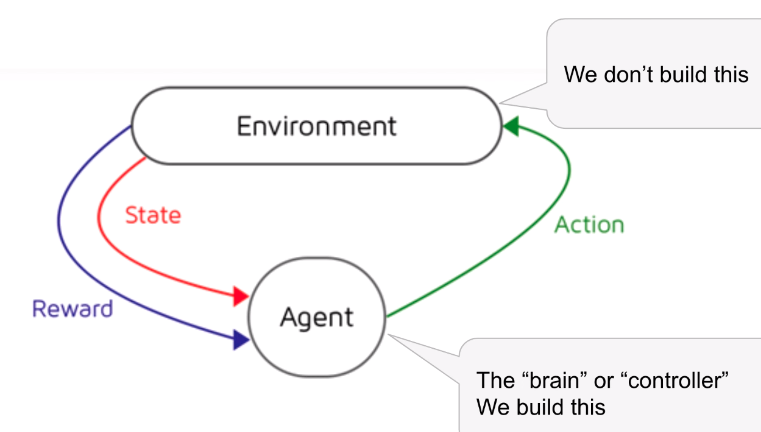
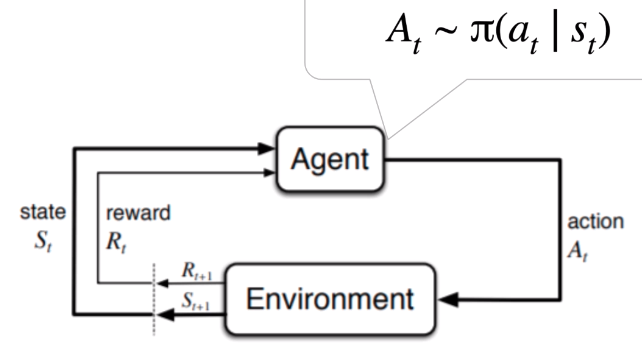
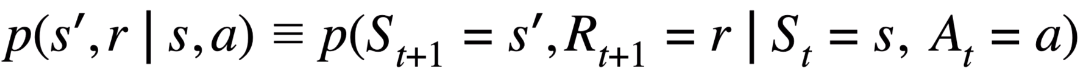

### Future Rewards
Goal is to not maximize reward in every episode but maximize the sum of all rewards. <br>
The goal at any given moment is to maximize the sum of future rewards which is known as __The Return__ (G).<br>
`G(t) = R(t+1) + R(t+2) + ... = sum [ R(t + τ + 1) ]`<br>
`G(t) = R(t+1) + G(t+1)`

#### Discounting
Inflation. Rewards in future not values same. Current worth of 10000 dollar machine in future is not 10000 dollars.<br>
Near future matter more. <br>
`G(t) = R(t+1) + γR(t+2) + γ2R(t+2)... = sum [ γ^τ * R(t + τ + 1) ]`<br>
`G(t) = R(t+1) + γG(t+1)`<br>
If γ = 0, G(t) = R(t+1) -- Greedy or short-sighted<br>
If γ = 1, G(t) = true sum of future rewards<br>
Hyperparameter to improve the training process. Generally close to 1. <br>

### The Return is Random
How to maximize the return value when there are many possible returns? (e.g., opponents choice in a game like tic-tac-to)<br>
What we wish to maximize is the __expected__ return (average return).<br>
The expected return is given by the __Value Function__. We write algorithms to solve this value function.<br>
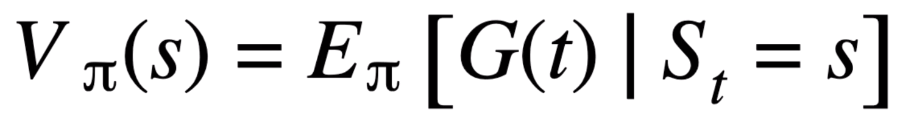

### The Bellman Equation

#### The Law of Total Expectation
`E(E(X|Y)) = E(X)`<br>
Using this, the value function can be re-written as
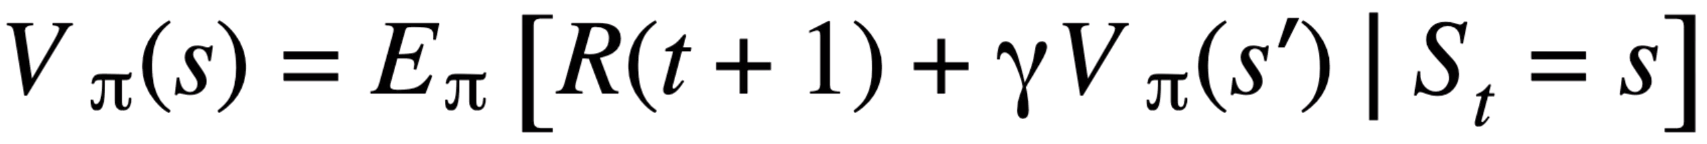<br>
where s' is value function at state t+1 i.e., St+1 = s'.<br>
Our agent can plan without actually having to look very far in the future. This equation only looks at the next step. <br>
Using this, solving value function reduces down to solving linear equations. <br>


#### Stochastic
In order to learn, we might want to perform new actions to improve our existing policy. Sum of future rewards may be different depending on which action is taken.
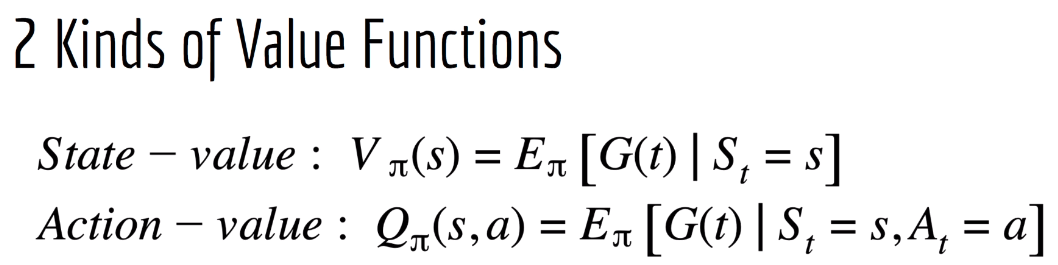
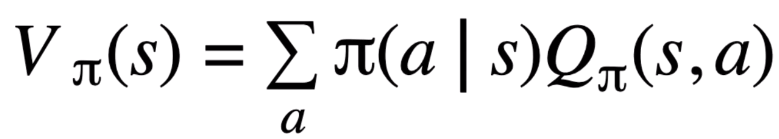<br>
State value - __V(s)__ is useful for evaluating a policy, the expected return?.<br>
Action value - __Q(s,a)__ is useful for control, best action to take in the current state. Expected future award, broken down by action. Compare Q(s,a1), Q(s,a2), take the action which has greater value<br>


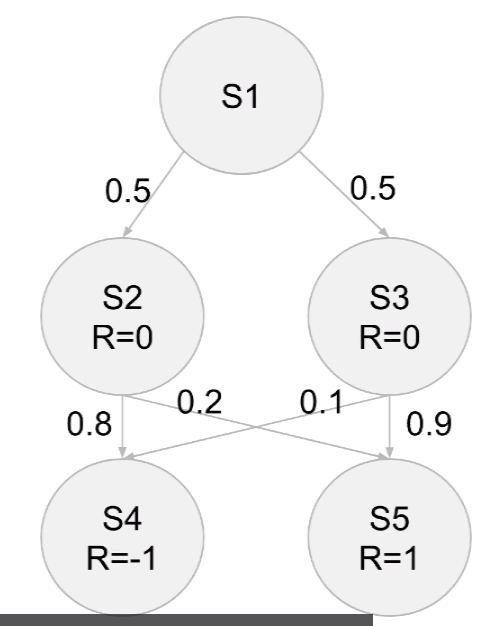
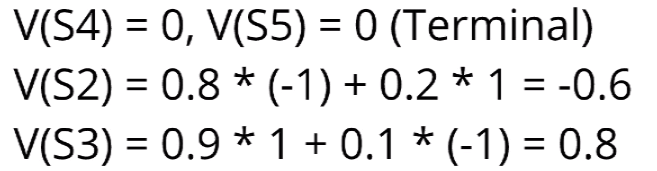
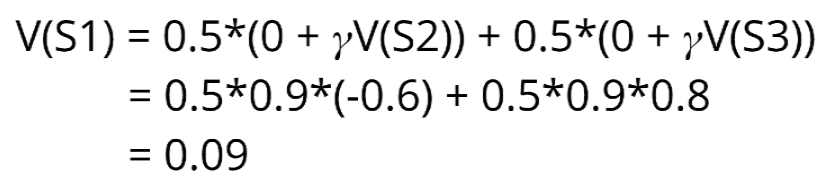<br>

#### Best Policy/Best Value Function
Best agent -> Best value function.<br>
Value function -> Policy used.<br>
How to compare policies (random, one direction etc.)?<br>
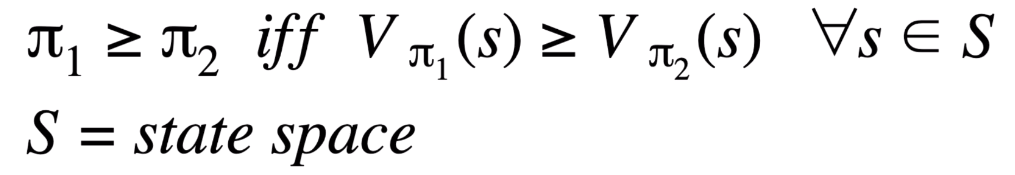<br>

##### Optimal Policy and Optimal Value Function
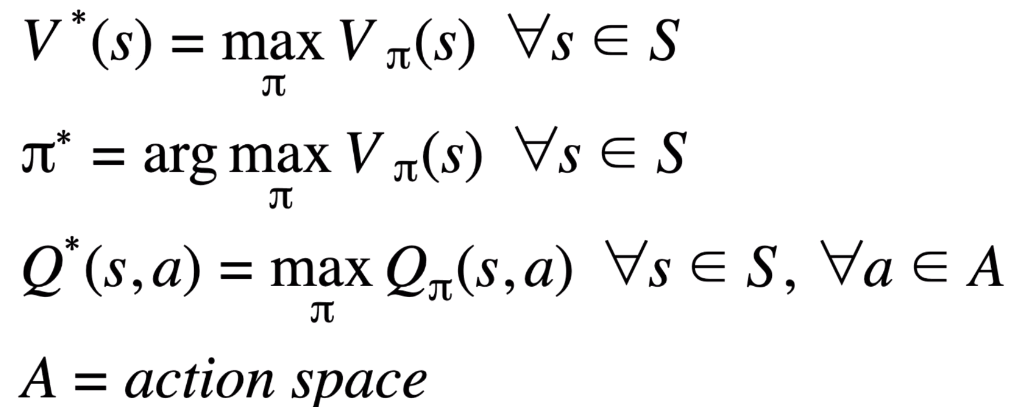

##### Bellman Optimality Equation
Instead of averaging over all possible actions, take the best action to find the optimal state value.
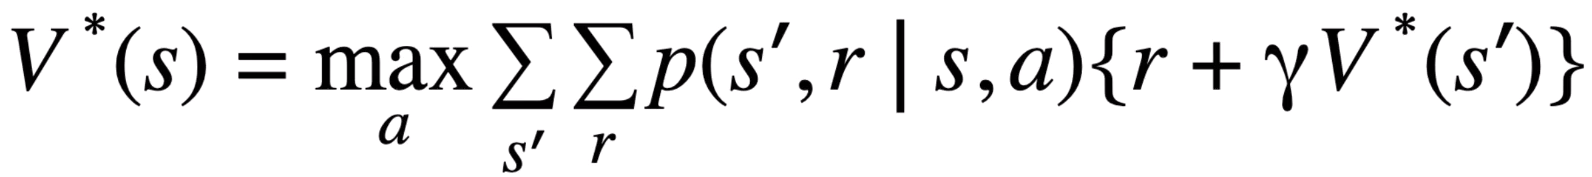<br>

#### How to use V* and Q* to find the best policy
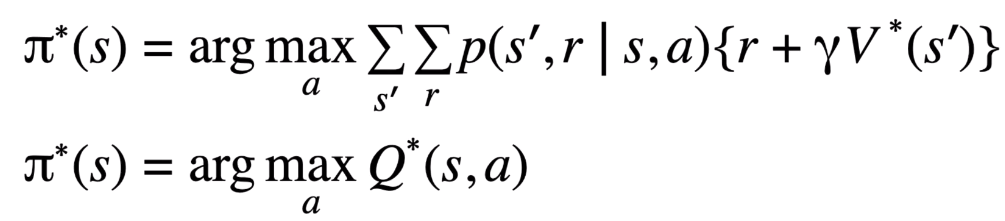<br>

For each algorithm,<br>
&emsp; Evaluation/Prediction (V)<br>
&emsp; &emsp; How to find V(s) for a given policy? TASK 1 - EVALUATE A POLICY<br>
&emsp; Control Problem (Q)<br>
&emsp; &emsp; How to find the best policy? TASK 2 - FIND THE BEST POLICY<br>
&emsp; &emsp; Find Q*<br>

## Dynamic Programming
Task 1)<br>
&emsp; Iterative policy evaluation

Task 2)<br>
&emsp; Policy improvement<br>
&emsp; Policy iteration<br>
&emsp; Value iteration<br>

### Policy Evaluation
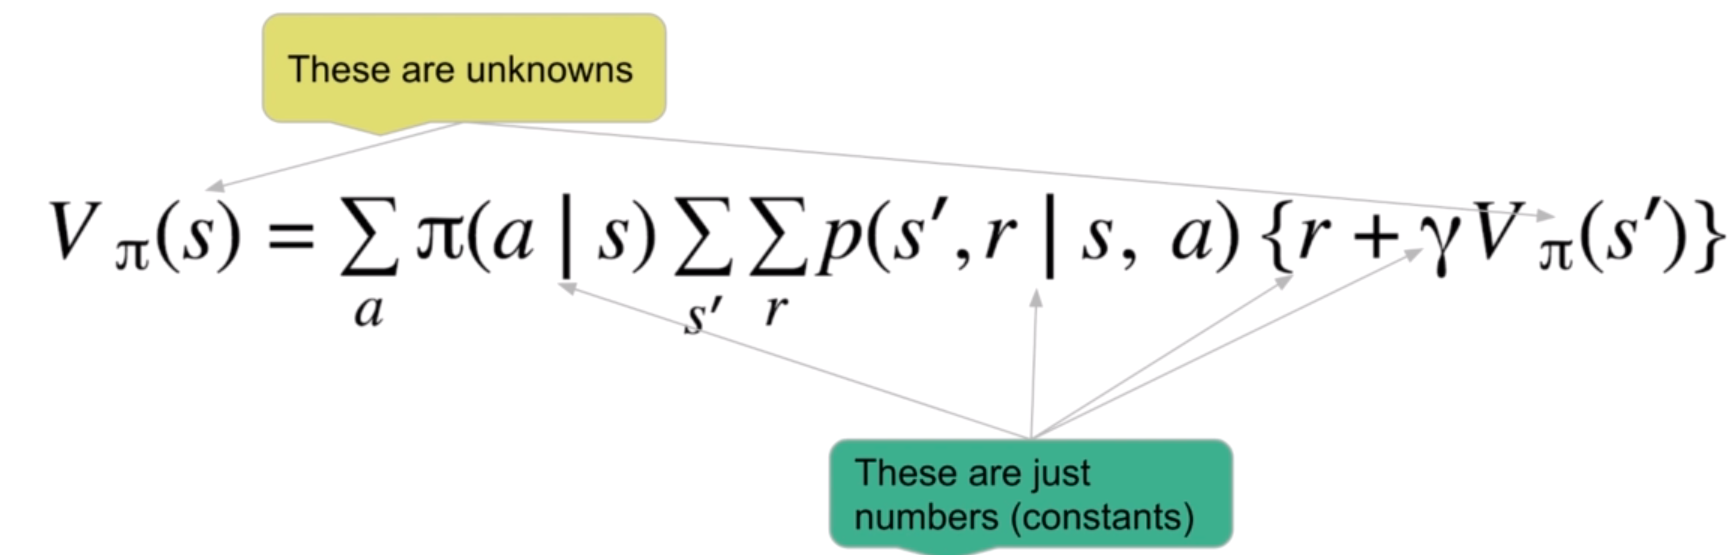

The DP approach: __Iterative Policy Evaluation__<br>
Initialize v0(s) = 0 or random<br>
vk+1 can be calculated using vk. The true value V_policy(s) is a fixed point for this update<br>
Calculuate vk till convergence. Stopping Condition: <br>
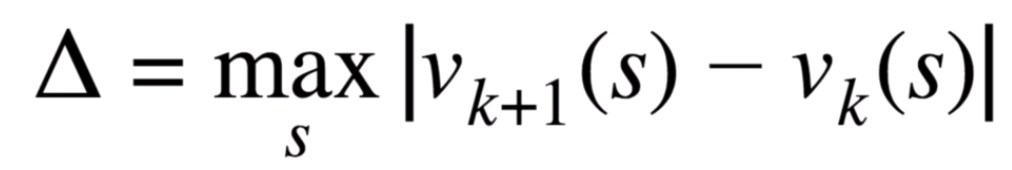<br>
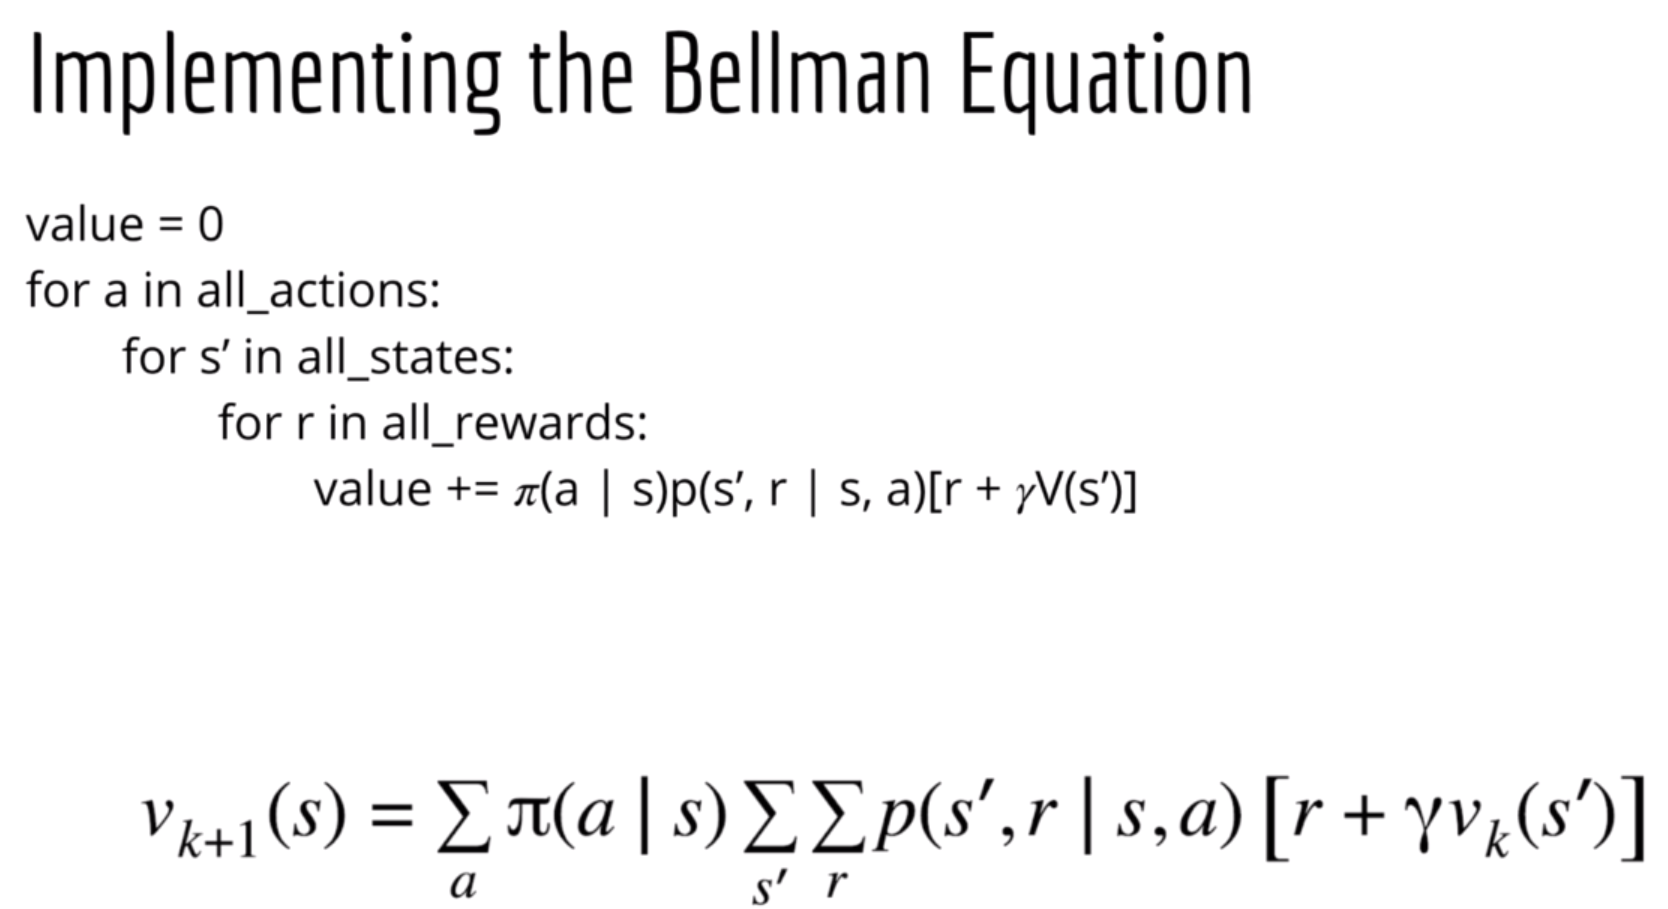<br>


### Gridworld Example

In [6]:
ACTION_SPACE = ('U', 'D', 'L', 'R')


class Grid: # Environment
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def reset(self):
    # put agent back in start position
    self.i = 2
    self.j = 0
    return (self.i, self.j)

  def get_next_state(self, s, a):
    # this answers: where would I end up if I perform action 'a' in state 's'?
    i, j = s[0], s[1]

    # if this action moves you somewhere else, then it will be in this dictionary
    if a in self.actions[(i, j)]:
      if a == 'U':
        i -= 1
      elif a == 'D':
        i += 1
      elif a == 'R':
        j += 1
      elif a == 'L':
        j -= 1
    return i, j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

### Steps
<ol>
    <li>Define helper function to print value and policy</li>
    <li>Create dictionaries for state transition probabilities and policy</li>
    <li>Apply iterative policy evaluation and find V(s)</li>
    <li>Print value / policy, check results</li>
</ol>

In [7]:
SMALL_ENOUGH = 1e-3 # threshold for convergence


def print_values(V, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")



if __name__ == '__main__':

  ### define transition probabilities and grid ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  # note: you could make it simpler by using r(s') since the reward doesn't
  # actually depend on (s, a)
  rewards = {}

  grid = standard_grid()
  for i in range(grid.rows):
    for j in range(grid.cols):
      s = (i, j)
      if not grid.is_terminal(s):
        for a in ACTION_SPACE:
          s2 = grid.get_next_state(s, a)
          transition_probs[(s, a, s2)] = 1
          if s2 in grid.rewards:
            rewards[(s, a, s2)] = grid.rewards[s2]

  ### fixed policy ###
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'R',
    (2, 2): 'U',
    (2, 3): 'L',
  }
  print_policy(policy, grid)

  # initialize V(s) = 0
  V = {}
  for s in grid.all_states():
    V[s] = 0

  gamma = 0.9 # discount factor

  # repeat until convergence
  it = 0
  while True:
    biggest_change = 0
    for s in grid.all_states():
      if not grid.is_terminal(s):
        old_v = V[s]
        new_v = 0 # we will accumulate the answer
        for a in ACTION_SPACE:
          for s2 in grid.all_states():

            # action probability is deterministic
            action_prob = 1 if policy.get(s) == a else 0
            
            # reward is a function of (s, a, s'), 0 if not specified
            r = rewards.get((s, a, s2), 0)
            new_v += action_prob * transition_probs.get((s, a, s2), 0) * (r + gamma * V[s2])

        # after done getting the new value, update the value table
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    print("iter:", it, "biggest_change:", biggest_change)
    print_values(V, grid)
    it += 1

    if biggest_change < SMALL_ENOUGH:
      break
  print("\n\n")

---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
iter: 0 biggest_change: 1.0
---------------------------
 0.00| 0.00| 1.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
iter: 1 biggest_change: 0.9
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.00| 0.00| 0.81| 0.00|
iter: 2 biggest_change: 0.7290000000000001
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.66| 0.73| 0.81| 0.73|
iter: 3 biggest_change: 0
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.66| 0.73| 0.81| 0.73|





In [8]:
class WindyGrid:
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions, probs):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions
    self.probs = probs

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    s = (self.i, self.j)
    a = action

    next_state_probs = self.probs[(s, a)]
    next_states = list(next_state_probs.keys())
    next_probs = list(next_state_probs.values())
    next_state_idx = np.random.choice(len(next_states), p=next_probs)
    s2 = next_states[next_state_idx]

    # update the current state
    self.i, self.j = s2

    # return a reward (if any)
    return self.rewards.get(s2, 0)

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def windy_grid():
  g = WindyGrid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }

  # p(s' | s, a) represented as:
  # KEY: (s, a) --> VALUE: {s': p(s' | s, a)}
  probs = {
    ((2, 0), 'U'): {(1, 0): 1.0},
    ((2, 0), 'D'): {(2, 0): 1.0},
    ((2, 0), 'L'): {(2, 0): 1.0},
    ((2, 0), 'R'): {(2, 1): 1.0},
    ((1, 0), 'U'): {(0, 0): 1.0},
    ((1, 0), 'D'): {(2, 0): 1.0},
    ((1, 0), 'L'): {(1, 0): 1.0},
    ((1, 0), 'R'): {(1, 0): 1.0},
    ((0, 0), 'U'): {(0, 0): 1.0},
    ((0, 0), 'D'): {(1, 0): 1.0},
    ((0, 0), 'L'): {(0, 0): 1.0},
    ((0, 0), 'R'): {(0, 1): 1.0},
    ((0, 1), 'U'): {(0, 1): 1.0},
    ((0, 1), 'D'): {(0, 1): 1.0},
    ((0, 1), 'L'): {(0, 0): 1.0},
    ((0, 1), 'R'): {(0, 2): 1.0},
    ((0, 2), 'U'): {(0, 2): 1.0},
    ((0, 2), 'D'): {(1, 2): 1.0},
    ((0, 2), 'L'): {(0, 1): 1.0},
    ((0, 2), 'R'): {(0, 3): 1.0},
    ((2, 1), 'U'): {(2, 1): 1.0},
    ((2, 1), 'D'): {(2, 1): 1.0},
    ((2, 1), 'L'): {(2, 0): 1.0},
    ((2, 1), 'R'): {(2, 2): 1.0},
    ((2, 2), 'U'): {(1, 2): 1.0},
    ((2, 2), 'D'): {(2, 2): 1.0},
    ((2, 2), 'L'): {(2, 1): 1.0},
    ((2, 2), 'R'): {(2, 3): 1.0},
    ((2, 3), 'U'): {(1, 3): 1.0},
    ((2, 3), 'D'): {(2, 3): 1.0},
    ((2, 3), 'L'): {(2, 2): 1.0},
    ((2, 3), 'R'): {(2, 3): 1.0},
    ((1, 2), 'U'): {(0, 2): 0.5, (1, 3): 0.5},
    ((1, 2), 'D'): {(2, 2): 1.0},
    ((1, 2), 'L'): {(1, 2): 1.0},
    ((1, 2), 'R'): {(1, 3): 1.0},
  }
  g.set(rewards, actions, probs)
  return g


def windy_grid_no_wind():
  g = windy_grid()
  g.probs[((1, 2), 'U')] = {(0, 2): 1.0}
  return g



def windy_grid_penalized(step_cost=-0.1):
  g = WindyGrid(3, 4, (2, 0))
  rewards = {
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
    (0, 3): 1,
    (1, 3): -1
  }
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }

  # p(s' | s, a) represented as:
  # KEY: (s, a) --> VALUE: {s': p(s' | s, a)}
  probs = {
    ((2, 0), 'U'): {(1, 0): 1.0},
    ((2, 0), 'D'): {(2, 0): 1.0},
    ((2, 0), 'L'): {(2, 0): 1.0},
    ((2, 0), 'R'): {(2, 1): 1.0},
    ((1, 0), 'U'): {(0, 0): 1.0},
    ((1, 0), 'D'): {(2, 0): 1.0},
    ((1, 0), 'L'): {(1, 0): 1.0},
    ((1, 0), 'R'): {(1, 0): 1.0},
    ((0, 0), 'U'): {(0, 0): 1.0},
    ((0, 0), 'D'): {(1, 0): 1.0},
    ((0, 0), 'L'): {(0, 0): 1.0},
    ((0, 0), 'R'): {(0, 1): 1.0},
    ((0, 1), 'U'): {(0, 1): 1.0},
    ((0, 1), 'D'): {(0, 1): 1.0},
    ((0, 1), 'L'): {(0, 0): 1.0},
    ((0, 1), 'R'): {(0, 2): 1.0},
    ((0, 2), 'U'): {(0, 2): 1.0},
    ((0, 2), 'D'): {(1, 2): 1.0},
    ((0, 2), 'L'): {(0, 1): 1.0},
    ((0, 2), 'R'): {(0, 3): 1.0},
    ((2, 1), 'U'): {(2, 1): 1.0},
    ((2, 1), 'D'): {(2, 1): 1.0},
    ((2, 1), 'L'): {(2, 0): 1.0},
    ((2, 1), 'R'): {(2, 2): 1.0},
    ((2, 2), 'U'): {(1, 2): 1.0},
    ((2, 2), 'D'): {(2, 2): 1.0},
    ((2, 2), 'L'): {(2, 1): 1.0},
    ((2, 2), 'R'): {(2, 3): 1.0},
    ((2, 3), 'U'): {(1, 3): 1.0},
    ((2, 3), 'D'): {(2, 3): 1.0},
    ((2, 3), 'L'): {(2, 2): 1.0},
    ((2, 3), 'R'): {(2, 3): 1.0},
    ((1, 2), 'U'): {(0, 2): 0.5, (1, 3): 0.5},
    ((1, 2), 'D'): {(2, 2): 1.0},
    ((1, 2), 'L'): {(1, 2): 1.0},
    ((1, 2), 'R'): {(1, 3): 1.0},
  }
  g.set(rewards, actions, probs)
  return g



def grid_5x5(step_cost=-0.1):
  g = Grid(5, 5, (4, 0))
  rewards = {(0, 4): 1, (1, 4): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'R'),
    (0, 3): ('L', 'D', 'R'),
    (1, 0): ('U', 'D', 'R'),
    (1, 1): ('U', 'D', 'L'),
    (1, 3): ('U', 'D', 'R'),
    (2, 0): ('U', 'D', 'R'),
    (2, 1): ('U', 'L', 'R'),
    (2, 2): ('L', 'R', 'D'),
    (2, 3): ('L', 'R', 'U'),
    (2, 4): ('L', 'U', 'D'),
    (3, 0): ('U', 'D'),
    (3, 2): ('U', 'D'),
    (3, 4): ('U', 'D'),
    (4, 0): ('U', 'R'),
    (4, 1): ('L', 'R'),
    (4, 2): ('L', 'R', 'U'),
    (4, 3): ('L', 'R'),
    (4, 4): ('L', 'U'),
  }
  g.set(rewards, actions)

  # non-terminal states
  visitable_states = actions.keys()
  for s in visitable_states:
    g.rewards[s] = step_cost

  return g

In [20]:
def print_values(V, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")



if __name__ == '__main__':

  ### define transition probabilities and grid ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  # we can take this from the grid object and convert it to the format we want
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  # note: you could make it simpler by using r(s') since the reward doesn't
  # actually depend on (s, a)
  rewards = {}

  grid = windy_grid()
  for (s, a), v in grid.probs.items():
    for s2, p in v.items():
      transition_probs[(s, a, s2)] = p
      rewards[(s, a, s2)] = grid.rewards.get(s2, 0)

  ### probabilistic policy ###
  policy = {
    (2, 0): {'U': 0.5, 'R': 0.5},
    (1, 0): {'U': 1.0},
    (0, 0): {'R': 1.0},
    (0, 1): {'R': 1.0},
    (0, 2): {'R': 1.0},
    (1, 2): {'U': 1.0},
    (2, 1): {'R': 1.0},
    (2, 2): {'U': 1.0},
    (2, 3): {'L': 1.0},
  }
  print_policy(policy, grid)

  # initialize V(s) = 0
  V = {}
  for s in grid.all_states():
    V[s] = 0

  gamma = 0.9 # discount factor

  # repeat until convergence
  it = 0
  while True:
    biggest_change = 0
    for s in grid.all_states():
      if not grid.is_terminal(s):
        old_v = V[s]
        new_v = 0 # we will accumulate the answer
        for a in ACTION_SPACE:
          for s2 in grid.all_states():

            # action probability is deterministic
            action_prob = policy[s].get(a, 0)
            
            # reward is a function of (s, a, s'), 0 if not specified
            r = rewards.get((s, a, s2), 0)
            new_v += action_prob * transition_probs.get((s, a, s2), 0) * (r + gamma * V[s2])

        # after done getting the new value, update the value table
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    print("iter:", it, "biggest_change:", biggest_change)
    print_values(V, grid)
    it += 1

    if biggest_change < SMALL_ENOUGH:
      break
  print("V:", V)
  print("\n\n")

  # sanity check
  # at state (1, 2), value is 0.5 * 0.9 * 1 + 0.5 * (-1) = -0.05

---------------------------
  {'R': 1.0}  |  {'R': 1.0}  |  {'R': 1.0}  |     |
---------------------------
  {'U': 1.0}  |     |  {'U': 1.0}  |     |
---------------------------
  {'U': 0.5, 'R': 0.5}  |  {'R': 1.0}  |  {'U': 1.0}  |  {'L': 1.0}  |
iter: 0 biggest_change: 1.0
---------------------------
 0.00| 0.00| 1.00| 0.00|
---------------------------
 0.00| 0.00|-0.50| 0.00|
---------------------------
 0.00| 0.00|-0.45| 0.00|
iter: 1 biggest_change: 0.9
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-0.05| 0.00|
---------------------------
-0.18|-0.41|-0.04|-0.41|
iter: 2 biggest_change: 0.4920750000000001
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-0.05| 0.00|
---------------------------
 0.31|-0.04|-0.04|-0.04|
iter: 3 biggest_change: 0
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-0.05| 0.00|
---------------------------
 0.31|-0.04|-0

#### Policy Improvement
Improve a step (take best action at a state i.e., argmax), compare rewards of improving this step Q(s,a) better than V(s). If yes, do it. => Improved BIATCH.

#### Policy Iteration
Initialize: Random Policy<br>
Loop:<br>
&emsp; V = evaluate policy <br>
&emsp; policy = improve policy using V <br>
&emsp; if new policy = old policy: break

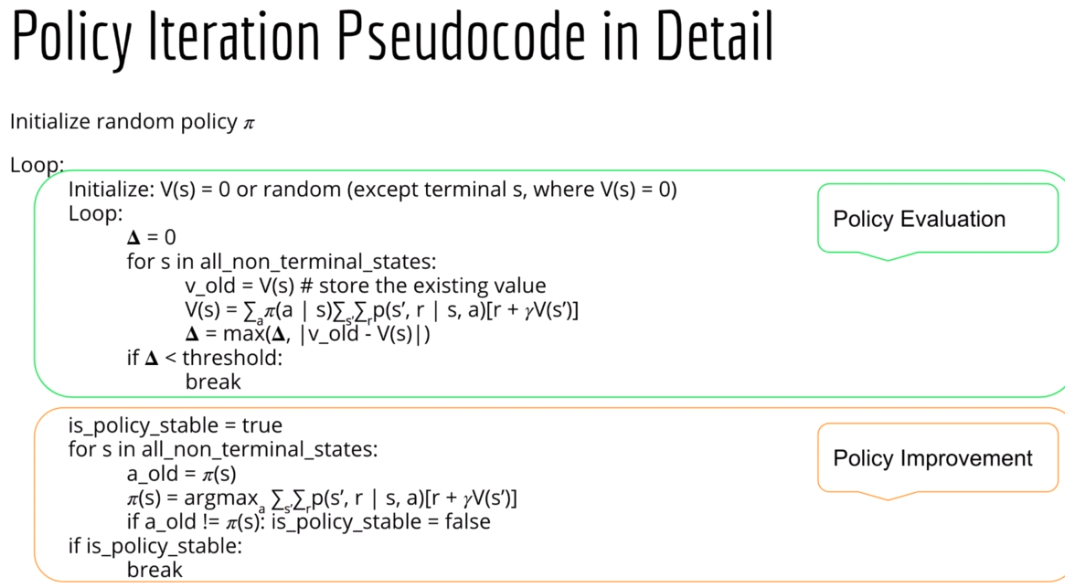

In [21]:

SMALL_ENOUGH = 1e-3
GAMMA = 0.9


# copied from iterative_policy_evaluation
def get_transition_probs_and_rewards(grid):
  ### define transition probabilities and grid ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  # note: you could make it simpler by using r(s') since the reward doesn't
  # actually depend on (s, a)
  rewards = {}

  for i in range(grid.rows):
    for j in range(grid.cols):
      s = (i, j)
      if not grid.is_terminal(s):
        for a in ACTION_SPACE:
          s2 = grid.get_next_state(s, a)
          transition_probs[(s, a, s2)] = 1
          if s2 in grid.rewards:
            rewards[(s, a, s2)] = grid.rewards[s2]

  return transition_probs, rewards


def evaluate_deterministic_policy(grid, policy, initV=None):
  # initialize V(s) = 0
  if initV is None:
    V = {}
    for s in grid.all_states():
      V[s] = 0
  else:
    # it's faster to use the existing V(s) since the value won't change
    # that much from one policy to the next
    V = initV

  # repeat until convergence
  it = 0
  while True:
    biggest_change = 0
    for s in grid.all_states():
      if not grid.is_terminal(s):
        old_v = V[s]
        new_v = 0 # we will accumulate the answer
        for a in ACTION_SPACE:
          for s2 in grid.all_states():

            # action probability is deterministic
            action_prob = 1 if policy.get(s) == a else 0
            
            # reward is a function of (s, a, s'), 0 if not specified
            r = rewards.get((s, a, s2), 0)
            new_v += action_prob * transition_probs.get((s, a, s2), 0) * (r + GAMMA * V[s2])

        # after done getting the new value, update the value table
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))
    it += 1

    if biggest_change < SMALL_ENOUGH:
      break
  return V


if __name__ == '__main__':

  grid = standard_grid()
  transition_probs, rewards = get_transition_probs_and_rewards(grid)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)

  # initial policy
  print("initial policy:")
  print_policy(policy, grid)

  # repeat until convergence - will break out when policy does not change
  V = None
  while True:

    # policy evaluation step - we already know how to do this!
    V = evaluate_deterministic_policy(grid, policy, initV=V)

    # policy improvement step
    is_policy_converged = True
    for s in grid.actions.keys():
      old_a = policy[s]
      new_a = None
      best_value = float('-inf')

      # loop through all possible actions to find the best current action
      for a in ACTION_SPACE:
        v = 0
        for s2 in grid.all_states():
          # reward is a function of (s, a, s'), 0 if not specified
          r = rewards.get((s, a, s2), 0)
          v += transition_probs.get((s, a, s2), 0) * (r + GAMMA * V[s2])

        if v > best_value:
          best_value = v
          new_a = a

      # new_a now represents the best action in this state
      policy[s] = new_a
      if new_a != old_a:
        is_policy_converged = False

    if is_policy_converged:
      break

  # once we're done, print the final policy and values
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
initial policy:
---------------------------
  U  |  R  |  D  |     |
---------------------------
  D  |     |  D  |     |
---------------------------
  L  |  L  |  R  |  D  |
values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.66| 0.73| 0.81| 0.73|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [29]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9


# copied from iterative_policy_evaluation
def get_transition_probs_and_rewards(grid):
  ### define transition probabilities and grid ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  # note: you could make it simpler by using r(s') since the reward doesn't
  # actually depend on (s, a)
  rewards = {}

  for (s, a), v in grid.probs.items():
    for s2, p in v.items():
      transition_probs[(s, a, s2)] = p
      rewards[(s, a, s2)] = grid.rewards.get(s2, 0)

  return transition_probs, rewards


def evaluate_deterministic_policy(grid, policy, initV=None):
  # initialize V(s) = 0
  if initV is None:
    V = {}
    for s in grid.all_states():
      V[s] = 0
  else:
    # it's faster to use the existing V(s) since the value won't change
    # that much from one policy to the next
    V = initV

  # repeat until convergence
  it = 0
  while True:
    biggest_change = 0
    for s in grid.all_states():
      if not grid.is_terminal(s):
        old_v = V[s]
        new_v = 0 # we will accumulate the answer
        for a in ACTION_SPACE:
          for s2 in grid.all_states():

            # action probability is deterministic
            action_prob = 1 if policy.get(s) == a else 0
            
            # reward is a function of (s, a, s'), 0 if not specified
            r = rewards.get((s, a, s2), 0)
            new_v += action_prob * transition_probs.get((s, a, s2), 0) * (r + GAMMA * V[s2])

        # after done getting the new value, update the value table
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))
    it += 1

    if biggest_change < SMALL_ENOUGH:
      break
  return V


if __name__ == '__main__':

  grid = windy_grid_penalized(-0.1)
  # grid = windy_grid()
  transition_probs, rewards = get_transition_probs_and_rewards(grid)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)

  # initial policy
  print("initial policy:")
  print_policy(policy, grid)

  # repeat until convergence - will break out when policy does not change
  V = None
  while True:

    # policy evaluation step - we already know how to do this!
    V = evaluate_deterministic_policy(grid, policy, initV=V)

    # policy improvement step
    is_policy_converged = True
    for s in grid.actions.keys():
      old_a = policy[s]
      new_a = None
      best_value = float('-inf')

      # loop through all possible actions to find the best current action
      for a in ACTION_SPACE:
        v = 0
        for s2 in grid.all_states():
          # reward is a function of (s, a, s'), 0 if not specified
          r = rewards.get((s, a, s2), 0)
          v += transition_probs.get((s, a, s2), 0) * (r + GAMMA * V[s2])

        if v > best_value:
          best_value = v
          new_a = a

      # new_a now represents the best action in this state
      policy[s] = new_a
      if new_a != old_a:
        is_policy_converged = False

    if is_policy_converged:
      break

  # once we're done, print the final policy and values
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
initial policy:
---------------------------
  U  |  R  |  R  |     |
---------------------------
  L  |     |  R  |     |
---------------------------
  D  |  R  |  U  |  L  |
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00|-0.04| 0.00|
---------------------------
 0.31| 0.18| 0.06|-0.04|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  D  |     |
---------------------------
  U  |  L  |  L  |  L  |


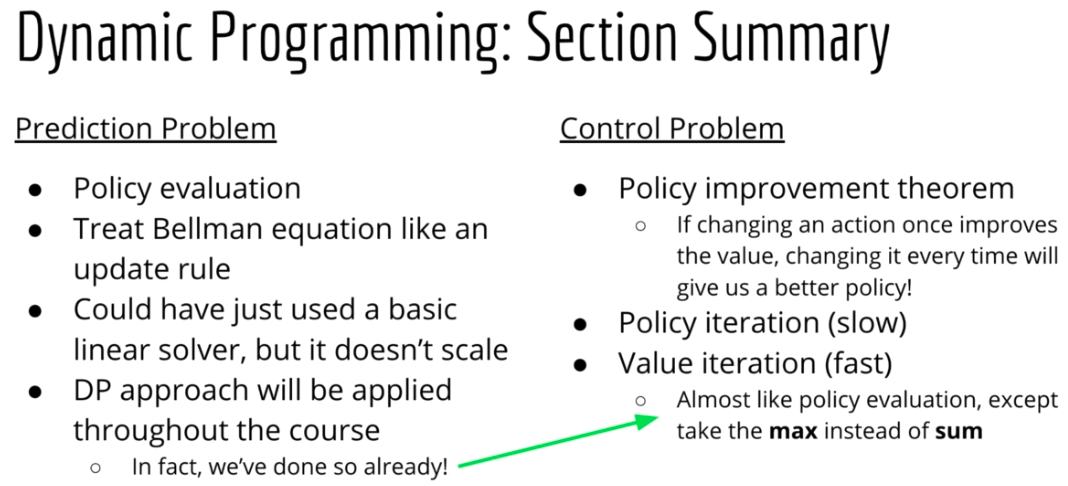

# Monte Carlo
Estimating expected value when the probability is unknown. Using samples, estimate the value using sample mean.


In [32]:
## PREDICTION PROBLEM

GAMMA = 0.9

# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy, max_steps=20):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()

  # keep track of all states and rewards encountered
  states = [s]
  rewards = [0]

  steps = 0
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    next_s = grid.current_state()

    # update states and rewards lists
    states.append(next_s)
    rewards.append(r)

    steps += 1
    if steps >= max_steps:
      break

    # update state
    # note: there is no need to store the final terminal state
    s = next_s

  # we want to return:
  # states  = [s(0), s(1), ..., S(T)]
  # rewards = [R(0), R(1), ..., R(T)]

  return states, rewards


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  # repeat
  for _ in range(100):
    # generate an episode using pi
    states, rewards = play_game(grid, policy)
    G = 0
    T = len(states)
    for t in range(T - 2, -1, -1):
      s = states[t]
      r = rewards[t+1]
      G = r + GAMMA * G # update return

      # we'll use first-visit Monte Carlo
      if s not in states[:t]:
        returns[s].append(G)
        V[s] = np.mean(returns[s])

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


### CONTROL PROBLEM
FIND V(s) for random policy. Improve each step, try again. Will converge at best policy.<br>
Easier to work with Q since we do not know some probabilities as discussed, but Q is easy.<br>
Estimating Q requires |S|x|A| values, V requires |S| values. Use value iteration to speed up i.e. combine improvement and value update into a single step.<br>
Monte Carlo strategy:<br>
&emsp; Play one episode, update Q with the returns we sampled.<br>
&emsp; Immediately update policy using latest Q

PROBLEM: We need to know Q for all possible actions to perform improvement step. We only collect G samples for actions we take according to the policy.<br>
SOLUTION: __THE EXPLORING STARTS METHOD__<br>
Each episode starts with a random state and action. Q(s,a) = sum of rewards for that episode. We can cover all states and actions simply by random selection.

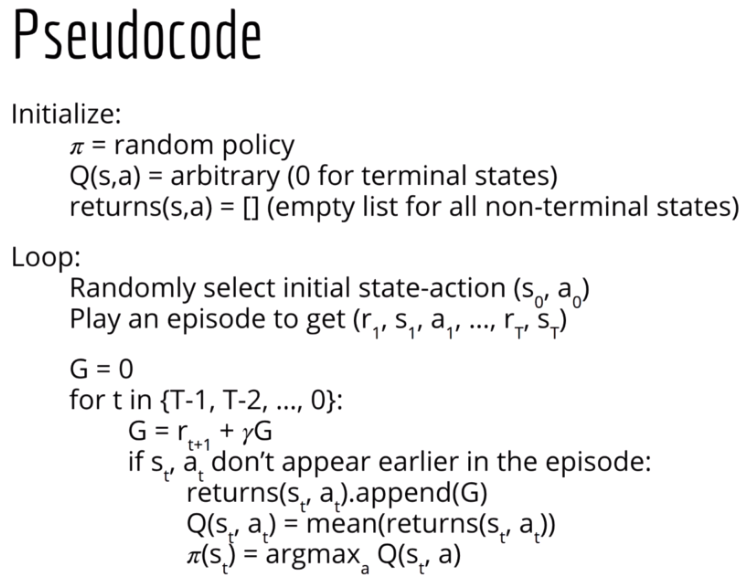<br>

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


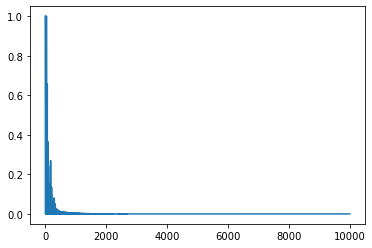

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |
final values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.66| 0.73| 0.81| 0.73|


In [33]:
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: this script implements the Monte Carlo Exploring-Starts method
#       for finding the optimal policy


def play_game(grid, policy, max_steps=20):
  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  states = [s]
  actions = [a]
  rewards = [0]

  for _ in range(max_steps):
    r = grid.move(a)
    s = grid.current_state()

    rewards.append(r)
    states.append(s)
    
    if grid.game_over():
      break
    else:
      a = policy[s]
      actions.append(a)

  # we want to return:
  # states  = [s(0), s(1), ..., s(T-1), s(T)]
  # actions = [a(0), a(1), ..., a(T-1),     ]
  # rewards = [   0, R(1), ..., R(T-1), R(T)]

  return states, actions, rewards


def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often

  # find max val
  max_val = max(d.values())

  # find keys corresponding to max val
  max_keys = [key for key, val in d.items() if val == max_val]

  ### slow version
  # max_keys = []
  # for key, val in d.items():
  #   if val == max_val:
  #     max_keys.append(key)

  return np.random.choice(max_keys), max_val


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  # grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  sample_counts = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      sample_counts[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        sample_counts[s][a] = 0
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for it in range(10000):
    if it % 1000 == 0:
      print(it)

    # generate an episode using pi
    biggest_change = 0
    states, actions, rewards = play_game(grid, policy)

    # create a list of only state-action pairs for lookup
    states_actions = list(zip(states, actions))

    T = len(states)
    G = 0
    for t in range(T - 2, -1, -1):
      # retrieve current s, a, r tuple
      s = states[t]
      a = actions[t]

      # update G
      G = rewards[t+1] + GAMMA * G

      # check if we have already seen (s, a) ("first-visit")
      if (s, a) not in states_actions[:t]:
        old_q = Q[s][a]
        sample_counts[s][a] += 1
        lr = 1 / sample_counts[s][a]
        Q[s][a] = old_q + lr * (G - old_q)

        # update policy
        policy[s] = max_dict(Q[s])[0]

        # update delta
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

#### Limitations of Exploring Starts
Not practical for real world, cannot start in any random state. We did ES to fill Q(s,a) for all s and all a since without samples we don't have any estimates. SOLUTION => __Epsilon-Greedy Monte Carlo Control__<br>
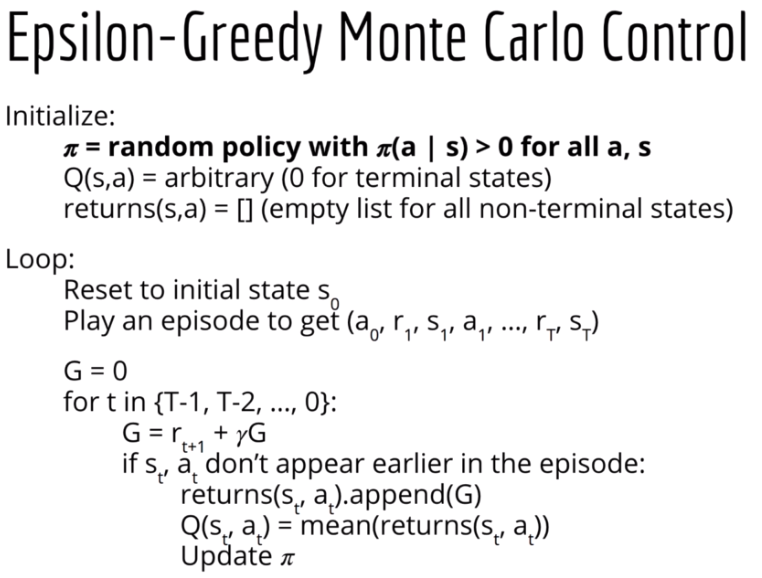<br>

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


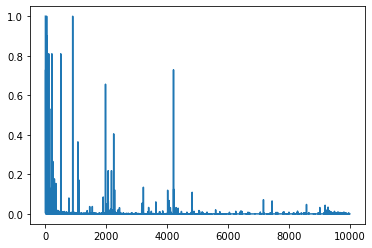

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
final values:
---------------------------
 0.79| 0.89| 1.00| 0.00|
---------------------------
 0.70| 0.00| 0.89| 0.00|
---------------------------
 0.62| 0.67| 0.75| 0.66|
state_sample_count:
         0       1        2      3
0   1014.0  1291.0  10534.0    0.0
1   1070.0     0.0   9545.0    0.0
2  10579.0  9853.0   9807.0  255.0


In [35]:
import pandas as pd

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')



def epsilon_greedy(policy, s, eps=0.1):
  p = np.random.random()
  if p < (1 - eps):
    return policy[s]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)


def play_game(grid, policy, max_steps=20):

  # start state
  s = grid.reset()

  # choose action
  a = epsilon_greedy(policy, s)

  states = [s]
  actions = [a]
  rewards = [0]

  for _ in range(max_steps):
    r = grid.move(a)
    s = grid.current_state()

    rewards.append(r)
    states.append(s)
    
    if grid.game_over():
      break
    else:
      a = epsilon_greedy(policy, s)
      actions.append(a)

  # we want to return:
  # states  = [s(0), s(1), ..., s(T-1), s(T)]
  # actions = [a(0), a(1), ..., a(T-1),     ]
  # rewards = [   0, R(1), ..., R(T-1), R(T)]

  return states, actions, rewards


def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often

  # find max val
  max_val = max(d.values())

  # find keys corresponding to max val
  max_keys = [key for key, val in d.items() if val == max_val]

  ### slow version
  # max_keys = []
  # for key, val in d.items():
  #   if val == max_val:
  #     max_keys.append(key)

  return np.random.choice(max_keys), max_val


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  # grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  sample_counts = {}
  state_sample_count = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      sample_counts[s] = {}
      state_sample_count[s] = 0
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        sample_counts[s][a] = 0
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for it in range(10000):
    if it % 1000 == 0:
      print(it)

    # generate an episode using pi
    biggest_change = 0
    states, actions, rewards = play_game(grid, policy)

    # create a list of only state-action pairs for lookup
    states_actions = list(zip(states, actions))

    T = len(states)
    G = 0
    for t in range(T - 2, -1, -1):
      # retrieve current s, a, r tuple
      s = states[t]
      a = actions[t]

      # update G
      G = rewards[t+1] + GAMMA * G

      # check if we have already seen (s, a) ("first-visit")
      if (s, a) not in states_actions[:t]:
        old_q = Q[s][a]
        sample_counts[s][a] += 1
        lr = 1 / sample_counts[s][a]
        Q[s][a] = old_q + lr * (G - old_q)

        # update policy
        policy[s] = max_dict(Q[s])[0]

        # update state sample count
        state_sample_count[s] += 1

        # update delta
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

  print("state_sample_count:")
  state_sample_count_arr = np.zeros((grid.rows, grid.cols))
  for i in range(grid.rows):
    for j in range(grid.cols):
      if (i, j) in state_sample_count:
        state_sample_count_arr[i,j] = state_sample_count[(i, j)]
  df = pd.DataFrame(state_sample_count_arr)
  print(df)

### Monte Carlo Summary
Actually learning from experience<br>
__Main idea__: Estimating expected values from samples
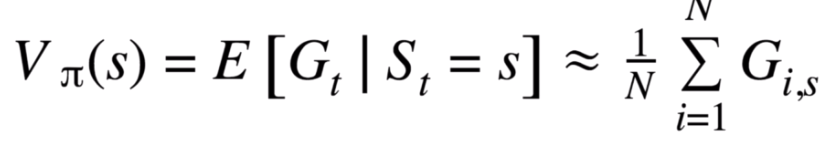<br>
Policy iteration / value iteration application<br>
Why we use Q(s,a) instead of V(s)<br>
The need for exploration starts / epsilon-greedy

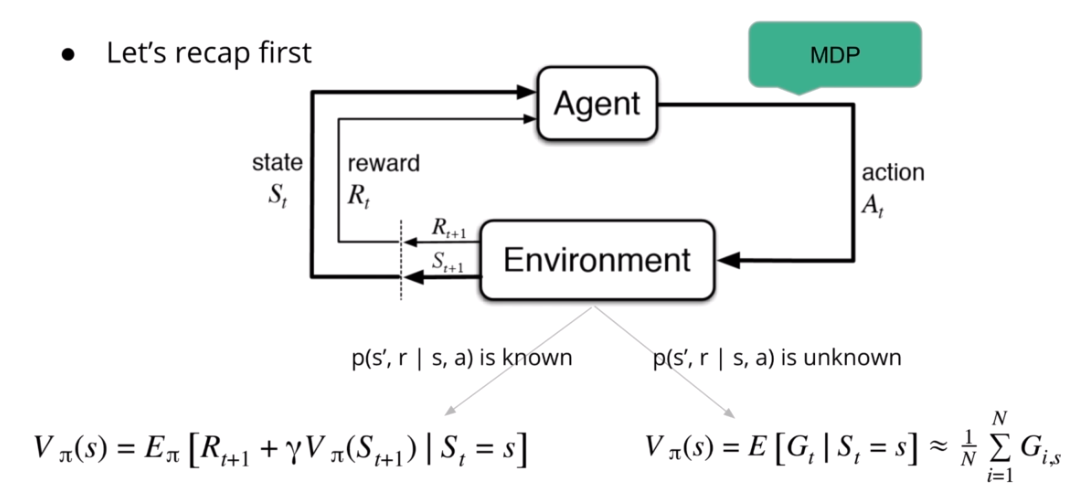

# Temporal Difference Learning
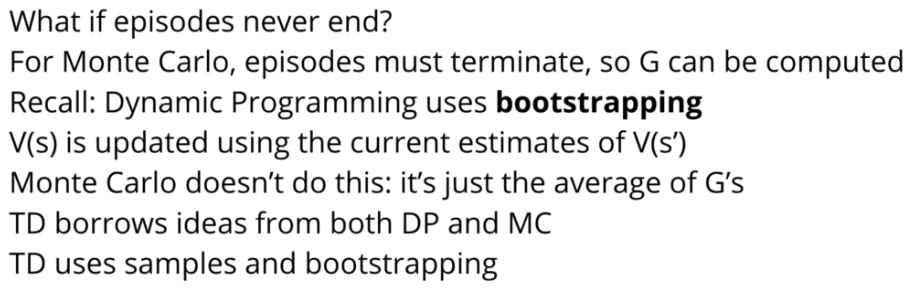

## TD Prediction
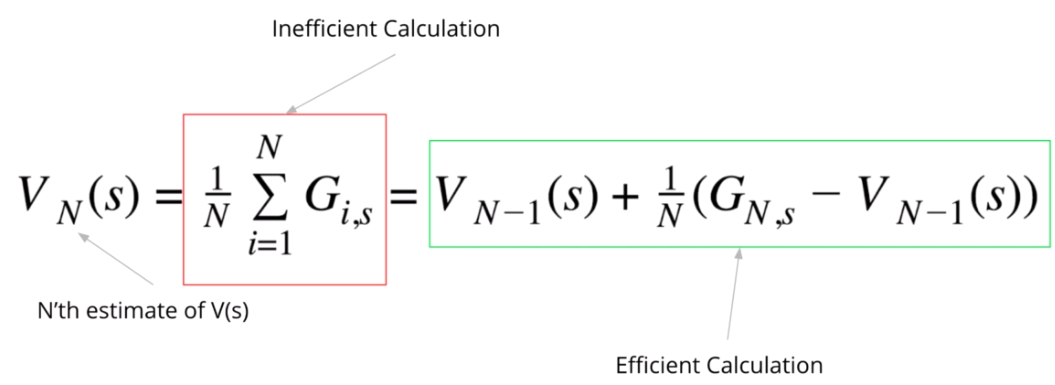<br>
### Constant Alpha / EWMA Monte Carlo
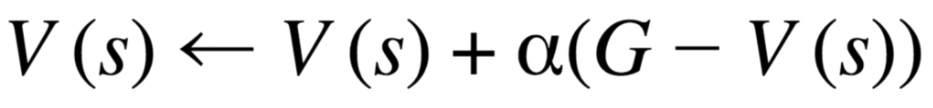

### Temporal Difference Learning
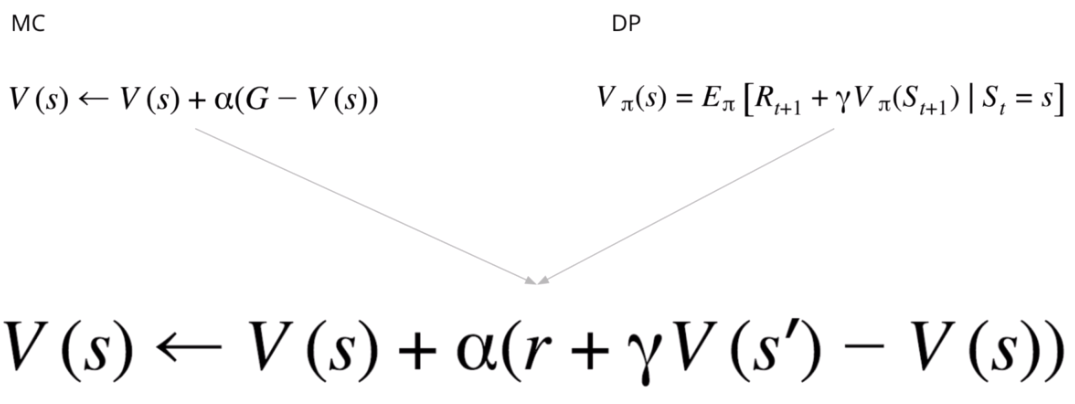

Agent can learn as it goes, does not have to wait for the episode to end to calculate G, as long as there is a single reward, an update can be made. Known reward r + estimate of future reward used to calculate next step (bootstrapping + sampling).

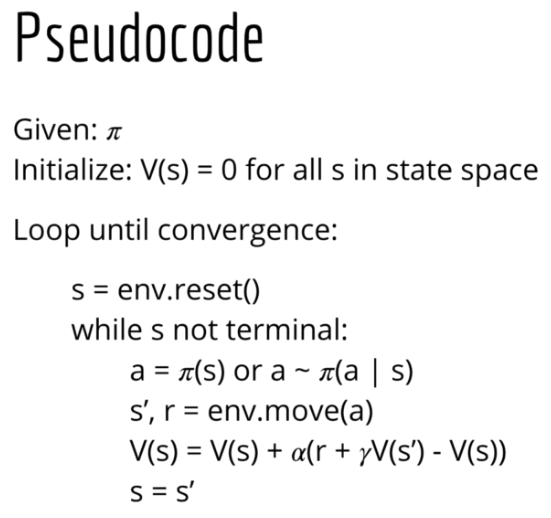

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


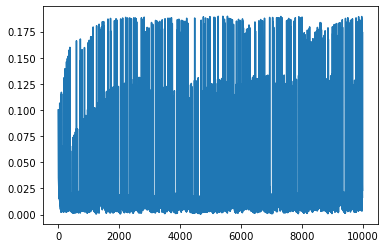

values:
---------------------------
 0.72| 0.75| 0.79| 0.00|
---------------------------
 0.66| 0.00|-0.99| 0.00|
---------------------------
 0.60|-0.78|-0.89|-0.99|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


In [36]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


def epsilon_greedy(policy, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return policy[s]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  states = grid.all_states()
  for s in states:
    V[s] = 0

  # store max change in V(s) per episode
  deltas = []

  # repeat until convergence
  n_episodes = 10000
  for it in range(n_episodes):
    # begin a new episode
    s = grid.reset()
    
    delta = 0
    while not grid.game_over():
      a = epsilon_greedy(policy, s)

      r = grid.move(a)
      s_next = grid.current_state()

      # update V(s)
      v_old = V[s]
      V[s] = V[s] + ALPHA*(r + GAMMA*V[s_next] - V[s])
      delta = max(delta, np.abs(V[s] - v_old))
      
      # next state becomes current state
      s = s_next

    # store delta
    deltas.append(delta)

  plt.plot(deltas)
  plt.show()

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

## SARSA - Temporal Difference Control
Sarsa = (s, a ,r, s', a')

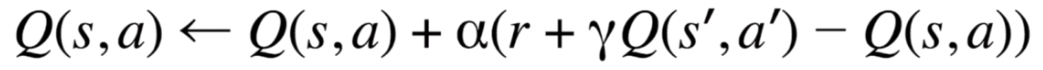
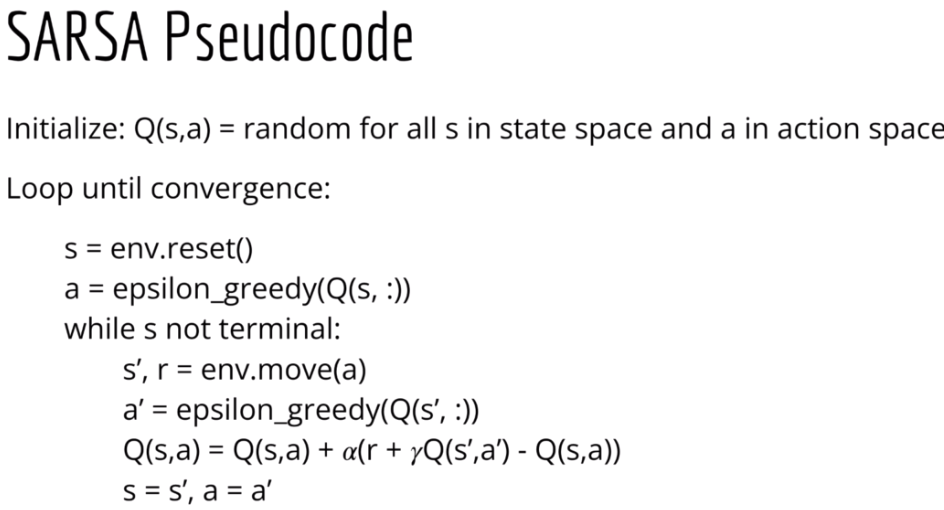


rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


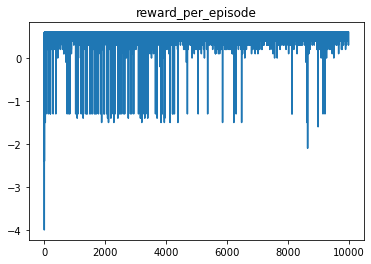

update counts:
---------------------------
 0.12| 0.12| 0.19| 0.00|
---------------------------
 0.12| 0.00| 0.08| 0.00|
---------------------------
 0.20| 0.08| 0.08| 0.00|
values:
---------------------------
 0.60| 0.80| 1.00| 0.00|
---------------------------
 0.42| 0.00| 0.78| 0.00|
---------------------------
 0.25| 0.39| 0.57| 0.37|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [38]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


def epsilon_greedy(Q, s, eps=0.1):
  if np.random.random() < eps:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)
  else:
    a_opt = max_dict(Q[s])[0]
    return a_opt


if __name__ == '__main__':
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}

  # repeat until convergence
  reward_per_episode = []
  for it in range(10000):
    if it % 2000 == 0:
      print("it:", it)

    # begin a new episode
    s = grid.reset()
    a = epsilon_greedy(Q, s, eps=0.1)
    episode_reward = 0
    while not grid.game_over():
      # perform action and get next state + reward
      r = grid.move(a)
      s2 = grid.current_state()

      # update reward
      episode_reward += r

      # get next action
      a2 = epsilon_greedy(Q, s2, eps=0.1)

      # update Q(s,a)
      Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*Q[s2][a2] - Q[s][a])

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
      a = a2

    # log the reward for this episode
    reward_per_episode.append(episode_reward)

  plt.plot(reward_per_episode)
  plt.title("reward_per_episode")
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)


## Q-Learning

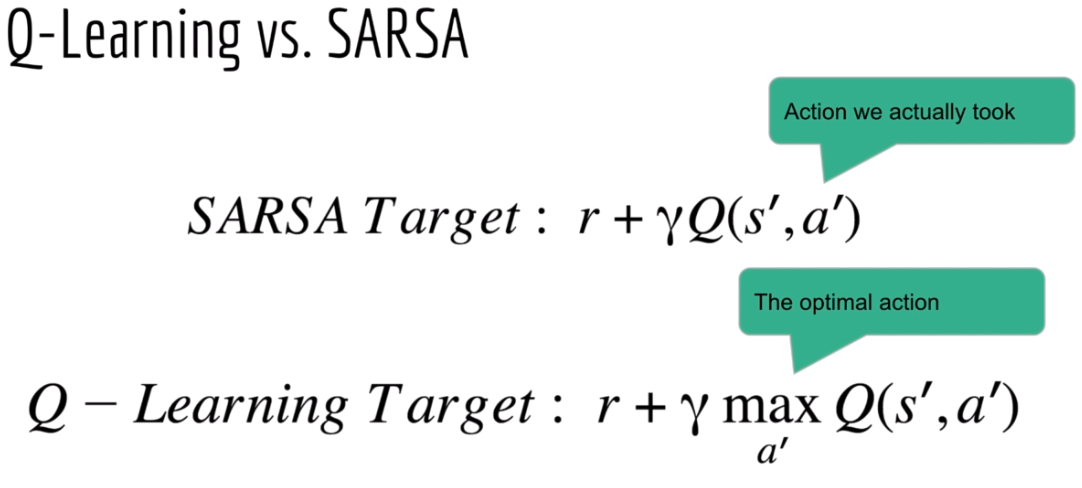
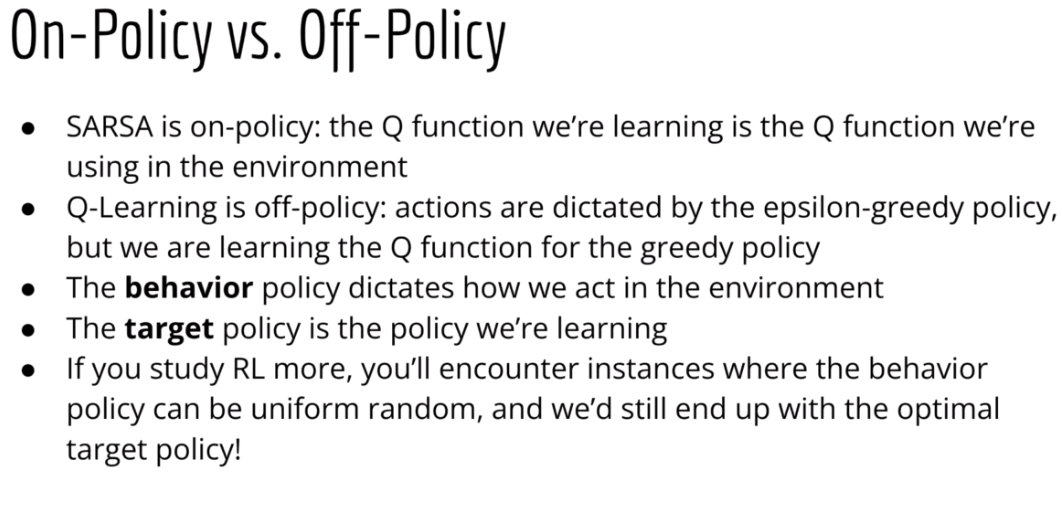
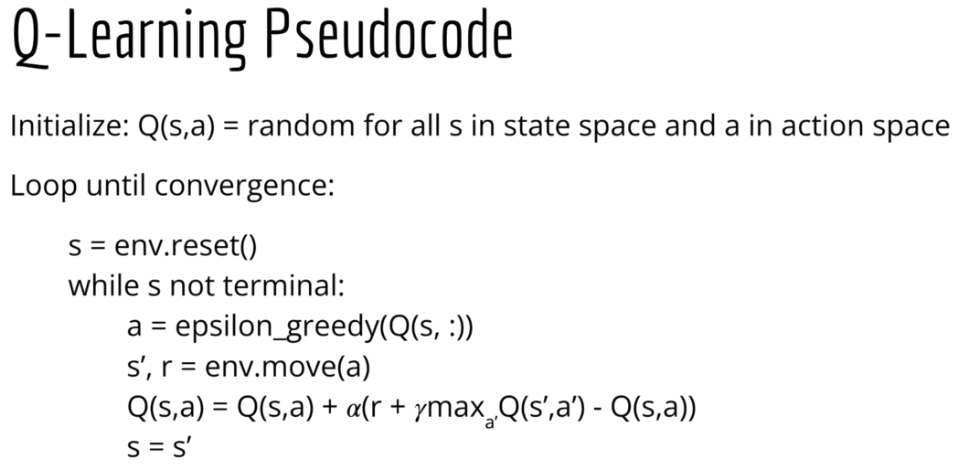

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


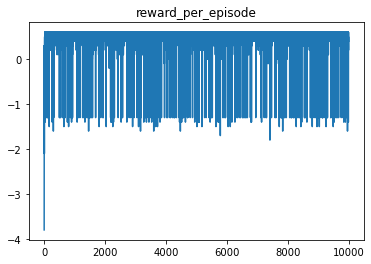

update counts:
---------------------------
 0.01| 0.01| 0.19| 0.00|
---------------------------
 0.01| 0.00| 0.19| 0.00|
---------------------------
 0.20| 0.20| 0.20| 0.01|
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |


In [40]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


def epsilon_greedy(Q, s, eps=0.1):
  if np.random.random() < eps:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)
  else:
    a_opt = max_dict(Q[s])[0]
    return a_opt


if __name__ == '__main__':
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}

  # repeat until convergence
  reward_per_episode = []
  for it in range(10000):
    if it % 2000 == 0:
      print("it:", it)

    # begin a new episode
    s = grid.reset()
    episode_reward = 0
    while not grid.game_over():
      # perform action and get next state + reward
      a = epsilon_greedy(Q, s, eps=0.1)
      r = grid.move(a)
      s2 = grid.current_state()

      # update reward
      episode_reward += r

      # update Q(s,a)
      maxQ = max_dict(Q[s2])[1]
      Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*maxQ - Q[s][a])

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2

    # log the reward for this episode
    reward_per_episode.append(episode_reward)

  plt.plot(reward_per_episode)
  plt.title("reward_per_episode")
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

# Approximation methods
__PROBLEM__: Tabular methods of storing states, actions, value function is limited.
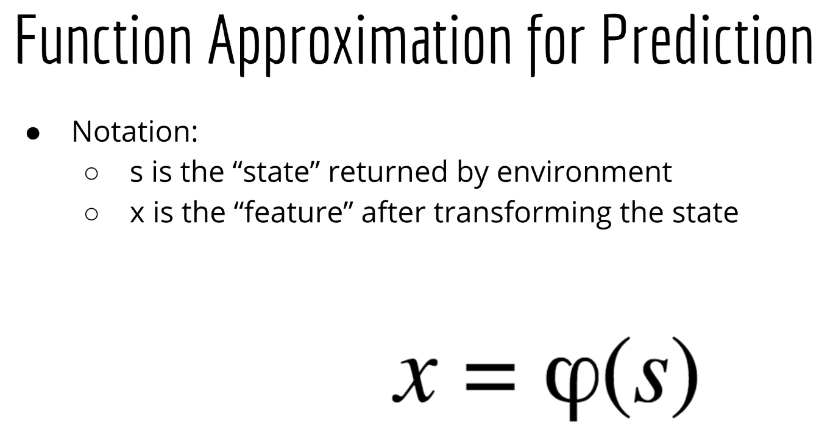
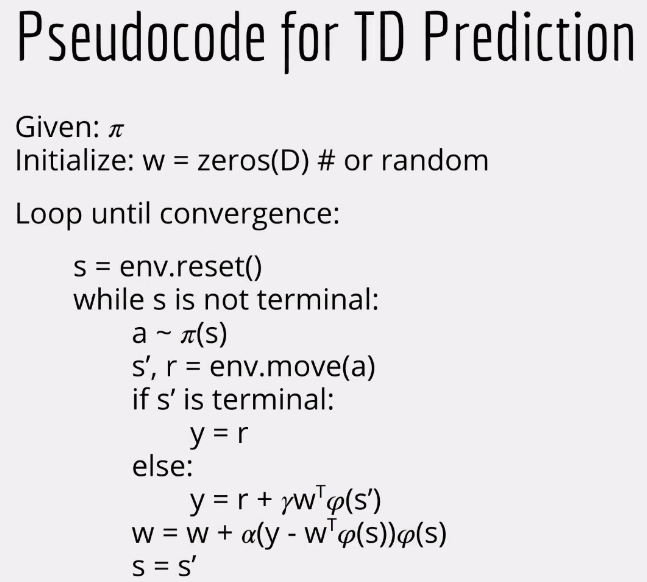


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


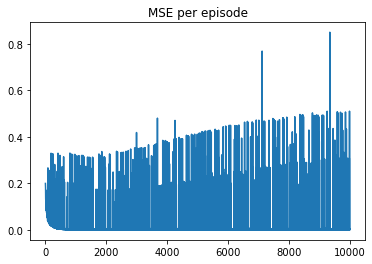

values:
---------------------------
 0.75| 0.84| 0.95| 0.00|
---------------------------
 0.66| 0.00|-0.87| 0.00|
---------------------------
 0.54|-0.59|-0.91|-0.94|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


In [41]:
from sklearn.kernel_approximation import Nystroem, RBFSampler

GAMMA = 0.9
ALPHA = 0.01
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


def epsilon_greedy(greedy, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return greedy[s]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)


def gather_samples(grid, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s = grid.reset()
    samples.append(s)
    while not grid.game_over():
      a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s = grid.current_state()
      samples.append(s)
  return samples


class Model:
  def __init__(self, grid):
    # fit the featurizer to data
    samples = gather_samples(grid)
    # self.featurizer = Nystroem()
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s):
    x = self.featurizer.transform([s])[0]
    return x @ self.w

  def grad(self, s):
    x = self.featurizer.transform([s])[0]
    return x


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  greedy_policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  model = Model(grid)
  mse_per_episode = []

  # repeat until convergence
  n_episodes = 10000
  for it in range(n_episodes):
    if (it + 1) % 100 == 0:
      print(it + 1)

    s = grid.reset()
    Vs = model.predict(s)
    n_steps = 0
    episode_err = 0
    while not grid.game_over():
      a = epsilon_greedy(greedy_policy, s)
      r = grid.move(a)
      s2 = grid.current_state()

      # get the target
      if grid.is_terminal(s2):
        target = r
      else:
        Vs2 = model.predict(s2)
        target = r + GAMMA * Vs2

      # update the model
      g = model.grad(s)
      err = target - Vs
      model.w += ALPHA * err * g
      
      # accumulate error
      n_steps += 1
      episode_err += err*err

      # update state
      s = s2
      Vs = Vs2
    
    mse = episode_err / n_steps
    mse_per_episode.append(mse)

  plt.plot(mse_per_episode)
  plt.title("MSE per episode")
  plt.show()

  # obtain predicted values
  V = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      V[s] = model.predict(s)
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(greedy_policy, grid)

In [ ]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ACTION2INT = {a: i for i, a in enumerate(ALL_POSSIBLE_ACTIONS)}
INT2ONEHOT = np.eye(len(ALL_POSSIBLE_ACTIONS))


def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return ALL_POSSIBLE_ACTIONS[np.argmax(values)]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)


def one_hot(k):
  return INT2ONEHOT[k]


def merge_state_action(s, a):
  ai = one_hot(ACTION2INT[a])
  return np.concatenate((s, ai))


def gather_samples(grid, n_episodes=1000):
  samples = []
  for _ in range(n_episodes):
    s = grid.reset()
    while not grid.game_over():
      a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      sa = merge_state_action(s, a)
      samples.append(sa)

      r = grid.move(a)
      s = grid.current_state()
  return samples


class Model:
  def __init__(self, grid):
    # fit the featurizer to data
    samples = gather_samples(grid)
    # self.featurizer = Nystroem()
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = merge_state_action(s, a)
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in ALL_POSSIBLE_ACTIONS]

  def grad(self, s, a):
    sa = merge_state_action(s, a)
    x = self.featurizer.transform([sa])[0]
    return x


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  model = Model(grid)
  reward_per_episode = []
  state_visit_count = {}

  # repeat until convergence
  n_episodes = 20000
  for it in range(n_episodes):
    if (it + 1) % 100 == 0:
      print(it + 1)

    s = grid.reset()
    state_visit_count[s] = state_visit_count.get(s, 0) + 1
    episode_reward = 0
    while not grid.game_over():
      a = epsilon_greedy(model, s)
      r = grid.move(a)
      s2 = grid.current_state()
      state_visit_count[s2] = state_visit_count.get(s2, 0) + 1

      # get the target
      if grid.game_over():
        target = r
      else:
        values = model.predict_all_actions(s2)
        target = r + GAMMA * np.max(values)

      # update the model
      g = model.grad(s, a)
      err = target - model.predict(s, a)
      model.w += ALPHA * err * g
      
      # accumulate reward
      episode_reward += r

      # update state
      s = s2
    
    reward_per_episode.append(episode_reward)

  plt.plot(reward_per_episode)
  plt.title("Reward per episode")
  plt.show()

  # obtain V* and pi*
  V = {}
  greedy_policy = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      values = model.predict_all_actions(s)
      V[s] = np.max(values)
      greedy_policy[s] = ALL_POSSIBLE_ACTIONS[np.argmax(values)]
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(greedy_policy, grid)


  print("state_visit_count:")
  state_sample_count_arr = np.zeros((grid.rows, grid.cols))
  for i in range(grid.rows):
    for j in range(grid.cols):
      if (i, j) in state_visit_count:
        state_sample_count_arr[i,j] = state_visit_count[(i, j)]
  df = pd.DataFrame(state_sample_count_arr)
  print(df)

## CartPole and OpenAI Gym


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler


GAMMA = 0.99
ALPHA = 0.1


def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return np.argmax(values)
  else:
    return model.env.action_space.sample()


def gather_samples(env, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s = env.reset()
    done = False
    while not done:
      a = env.action_space.sample()
      sa = np.concatenate((s, [a]))
      samples.append(sa)

      s, r, done, info = env.step(a)
  return samples


class Model:
  def __init__(self, env):
    # fit the featurizer to data
    self.env = env
    samples = gather_samples(env)
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in range(self.env.action_space.n)]

  def grad(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x


def test_agent(model, env, n_episodes=20):
  reward_per_episode = np.zeros(n_episodes)
  for it in range(n_episodes):
    done = False
    episode_reward = 0
    s = env.reset()
    while not done:
      a = epsilon_greedy(model, s, eps=0)
      s, r, done, info = env.step(a)
      episode_reward += r
    reward_per_episode[it] = episode_reward
  return np.mean(reward_per_episode)


def watch_agent(model, env, eps):
  done = False
  episode_reward = 0
  s = env.reset()
  while not done:
    a = epsilon_greedy(model, s, eps=eps)
    s, r, done, info = env.step(a)
    env.render()
    episode_reward += r
  print("Episode reward:", episode_reward)


if __name__ == '__main__':
  # instantiate environment
  env = gym.make("CartPole-v0")

  model = Model(env)
  reward_per_episode = []

  # watch untrained agent
  watch_agent(model, env, eps=0)

  # repeat until convergence
  n_episodes = 1500
  for it in range(n_episodes):
    s = env.reset()
    episode_reward = 0
    done = False
    while not done:
      a = epsilon_greedy(model, s)
      s2, r, done, info = env.step(a)

      # get the target
      if done:
        target = r
      else:
        values = model.predict_all_actions(s2)
        target = r + GAMMA * np.max(values)

      # update the model
      g = model.grad(s, a)
      err = target - model.predict(s, a)
      model.w += ALPHA * err * g
      
      # accumulate reward
      episode_reward += r

      # update state
      s = s2

    if (it + 1) % 50 == 0:
      print(f"Episode: {it + 1}, Reward: {episode_reward}")

    # early exit
    if it > 20 and np.mean(reward_per_episode[-20:]) == 200:
      print("Early exit")
      break
    
    reward_per_episode.append(episode_reward)

  # test trained agent
  test_reward = test_agent(model, env)
  print(f"Average test reward: {test_reward}")

  plt.plot(reward_per_episode)
  plt.title("Reward per episode")
  plt.show()

  # watch trained agent
  watch_agent(model, env, eps=0)